# Flux tutorial

## Load `pybhpt.flux`

In [4]:
from pybhpt.teuk import TeukolskyMode
from pybhpt.flux import FluxMode
from pybhpt.geo import KerrGeodesic
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

## Solving the inhomogeneous radial Teukolsky equation in Kerr spacetime

The `TeukolskyMode` class constructs modes of the so-called extended homogeneous solutions to the radial Teukolsky equation for a point-particle source on a bound periodic geodesic,
$$\begin{align}
    \Psi_s &= \Psi_s^+ \Theta(r-r_p) + \Psi_s^- \Theta(r_p-r),
    \\
    \Psi_s^\pm &= \sum_{jmkn}\Psi^\pm_{sjmkn}(r)S_{sj\gamma_{mkn}}(\theta)e^{im\phi}e^{-i\omega_{mkn}t},
\end{align}$$
where we have the mode frequencies $\omega_{mkn} = m\Omega_\phi + k \Omega_\theta + n \Omega_r$, the discrete spheroidicity $\gamma_{mkn} = a\omega_{mkn}$, and the extended homogeneous radial solutions
$$
    \Psi^\pm_{sjmkn}(r) = Z^{\mathrm{Up/In}}_{sjmkn} R^{\mathrm{Up/In}}_{sjmkn}(r),
$$
with Teukolsky amplitudes $Z^{\mathrm{Up/In}}_{sjmkn}$. The code currently supports spin-weights $s= 0, \pm 2$, corresponding the scalar perturbations $\Psi_0 = \Phi$ and curvature perturbations $\Psi_{2} = \psi_0$, $\Psi_{-2} = (r-ia\cos\theta)^{4} \psi_4$.

The class is instantiated with the input parameters

- $s$ : spin-weight of the perturbation
- $j$ : the spheroidal polar mode number
- $m$ : the azimuthal mode number
- $k$ : the polar mode number
- $n$ : the radial mode number

along with an instance of the `KerrGeodesic` class that captures the motion of the source.

In [5]:
a, p, e, x = 0.99, 5, 0.6, 0.4
geo = KerrGeodesic(a, p, e, x)

In [6]:
s, j, m, k, n = -2, 12, 3, 1, 2
Psis = TeukolskyMode(s, j, m, k, n, geo)

We solve for the mode solutions and the Teukolsky amplitudes with the `solve()` method

In [7]:
Psis.solve(geo)

## Generating flux contribution from each Teukolsky mode

The time-averaged rate of change of the orbital energy $\langle \dot{E}\rangle$, angular momentum $\langle \dot{L}_z\rangle$, and Carter constant $\langle \dot{Q}\rangle$ can be expressed in terms of the Teukolsky amplitudes $Z^\mathrm{Up/In}_{sjmkn}$,
$$ 
\begin{align}
\langle \dot{\mathcal{J}} \rangle & = \langle \dot{\mathcal{J}} \rangle^\mathrm{inf} + \langle \dot{\mathcal{J}} \rangle^\mathrm{hor},
\\
&= \sum_{jmkn} \langle \dot{\mathcal{J}} \rangle^\mathrm{inf/hor}_{jmkn},
\\ 
&= \sum_{jmkn} \alpha_{sjmkn}^{(\mathcal{J})\mathrm{inf/hor}}\left| Z^\mathrm{Up/In}_{sjmkn} \right|^2,
\end{align}$$
where $\mathcal{J} = (E, L_z, Q)$, $\alpha_{sjmkn}^{(\mathcal{J})\mathrm{inf}/\mathrm{hor}}$ are known coefficients, and $s=0, \pm 2$ produce either scalar or gravitational fluxes, respectively. 

The `FluxMode` class takes as input an instances of the Kerr geodesic class and the Teukolsky class for a mode $(s,j,m,k,n)$, and produces the flux contribution for that given mode.

In [9]:
flux = FluxMode(geo, Psis)

Then we can access the horizon fluxes, infinity fluxes, and total fluxes, which are stored in lists with the order of $\mathcal{J} = (E, L_z, Q)$

In [12]:
print(flux.horizonfluxes)
print(flux.infinityfluxes)
print(flux.totalfluxes)

[-3.606222842872166e-36, -3.5075219557527026e-35, -1.979059439027494e-34]
[6.753687090778148e-25, 6.56884135710292e-24, 3.7063566971910574e-23]
[6.753687090742086e-25, 6.568841357067845e-24, 3.706356697171267e-23]


## Example: Circular Kerr fluxes

As a quick example, we compute the total fluxes for a particle on a circular Kerr geodesic

In [14]:
a, p, e, x = 0.99, 5, 0., 1.
geo = KerrGeodesic(a, p, e, x, nsamples=2**2)

In [45]:
jmax = 18
total_fluxes = np.zeros(3)
horizon_fluxes = np.zeros(3)
infinity_fluxes = np.zeros(3)
total_fluxes_jmodes = np.zeros((jmax - 1, 3))
for j in range(2, jmax+1):
    for m in range(1, j+1):
        Psis = TeukolskyMode(-2, j, m, 0, 0, geo, auto_solve=True)
        flux = FluxMode(geo, Psis)
        total_fluxes += flux.totalfluxes
        total_fluxes_jmodes[j-2] += flux.totalfluxes
        horizon_fluxes += flux.horizonfluxes
        infinity_fluxes += flux.infinityfluxes
total_fluxes *= 2
horizon_fluxes *= 2
infinity_fluxes *= 2
total_fluxes_jmodes *= 2

In [46]:
print("Total fluxes (E, Lz, Q): ", total_fluxes)

Total fluxes (E, Lz, Q):  [0.00122957 0.01496423 0.        ]


We can also plot the convergence of the mode-sum, which we see falls-off exponentially

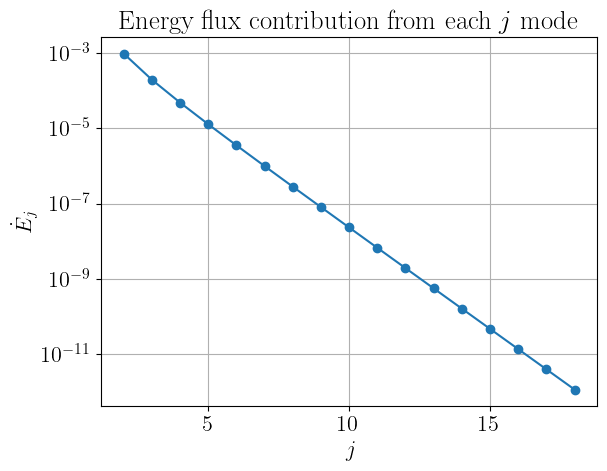

In [47]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 16

plt.plot(range(2, jmax+1), total_fluxes_jmodes[:, 0], 'o-')
plt.yscale('log')
plt.xlabel('$j$')
plt.ylabel('$\dot{E}_{j}$')
plt.title('Energy flux contribution from each $j$ mode')
plt.grid()
plt.show()